In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import *
from matplotlib.pyplot import figure

Using TensorFlow backend.


In [3]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [45]:
import pandas as pd
df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')

In [5]:
# df = df.sort_values(by=['label'])

In [46]:
label_tag = (list(set (df.label)))
label_tag.sort()
cutdata = []
for i in range (len(label_tag)):
    df_go = df[df.label == label_tag[i]].head(100000)    
    cutdata.append(df_go)

In [47]:
go = pd.concat(cutdata, axis = 0)

Text(0.5, 0, 'Label')

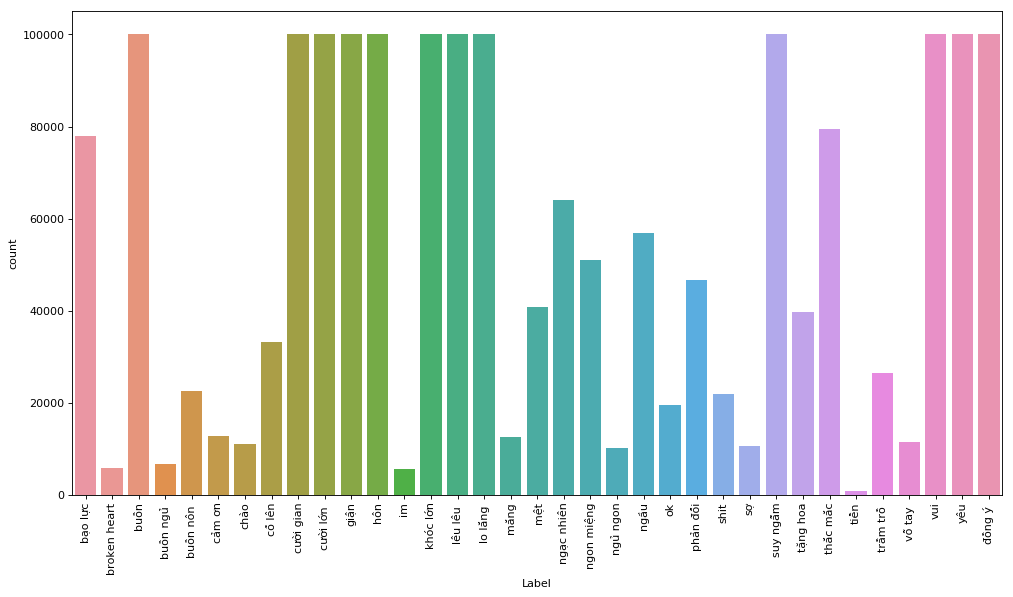

In [48]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(go.label)
plt.xlabel('Label')

In [49]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [50]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [51]:
Y = np.array(onehot_Y)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 11)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=11)

In [53]:
# max_words = len(X_train)+1
max_words = 88857
max_len = 30
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [30]:
len(X_train)

1378221

In [54]:
len(X_train)

3457168

In [31]:
len(word_dict)

88856

In [14]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [15]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [36]:
w = np.random.normal(0, 1, (max_words, 300))

In [37]:
for i in range (1, len(tok.index_word)):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [55]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [56]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 30, 300)           26657100  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 35)                8995      
__________

In [57]:
# Compatible with tensorflow backend
import tensorflow as tf
# def focal_loss(gamma=10, alpha=.25):
def focal_loss(gamma=10, alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [58]:
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

## focal loss
# model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')

In [59]:
weight_file = "model_LSTM_w10.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [61]:
history = model.fit(sequences_matrix,Y_train,batch_size = 512, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

Train on 2765734 samples, validate on 691434 samples
Epoch 1/10
2765734/2765734 [==============================] - 346s 125us/step - loss: 2.4293 - acc: 0.2635 - val_loss: 2.3747 - val_acc: 0.2757

Epoch 00001: val_loss improved from inf to 2.37468, saving model to model_LSTM_w10.hdf5
Epoch 2/10
2765734/2765734 [==============================] - 368s 133us/step - loss: 2.3763 - acc: 0.2774 - val_loss: 2.3563 - val_acc: 0.2799

Epoch 00002: val_loss improved from 2.37468 to 2.35632, saving model to model_LSTM_w10.hdf5
Epoch 3/10
2765734/2765734 [==============================] - 346s 125us/step - loss: 2.3570 - acc: 0.2824 - val_loss: 2.3534 - val_acc: 0.2828

Epoch 00003: val_loss improved from 2.35632 to 2.35343, saving model to model_LSTM_w10.hdf5
Epoch 4/10
2765734/2765734 [==============================] - 347s 125us/step - loss: 2.3451 - acc: 0.2859 - val_loss: 2.3478 - val_acc: 0.2836

Epoch 00004: val_loss improved from 2.35343 to 2.34783, saving model to model_LSTM_w10.hdf5
Epo

In [63]:
X_test = [str(s) for s in X_test]
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

864293/864293 [==============================] - 439s 508us/step


In [64]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 2.365
  Accuracy: 0.281
